# Notebook: IELTS Writing Task 2 Scoring with Mistral-7B-Instruct-v0.2 (Kaggle)

This notebook demonstrates how to use the Mistral-7B-Instruct-v0.2 model to automatically score IELTS Writing Task 2 essays. The pipeline uses standardized schemas, validation, prompts, and batch evaluation as in the reference system.

In [2]:
# Section 1: Install and import required libraries
!pip install --upgrade pip
!pip install -q transformers accelerate torch jsonschema

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import base64
from jsonschema import validate, ValidationError

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
# Section 2: Load Mistral-7B-Instruct model directly from Hugging Face
import os

MODEL_NAME = 'mistralai/Mistral-7B-Instruct-v0.2'
TOKENIZER_DIR = '/kaggle/working/mistral-7b-instruct-v0.2-tokenizer-cache'
MODEL_DIR = '/kaggle/working/mistral-7b-instruct-v0.2-cache'

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_Token")


# Load Hugging Face token from environment variable
if not hf_token:
    raise ValueError("Please set the HF_TOKEN environment variable with your Hugging Face access token.")

if os.path.exists(MODEL_DIR) and os.path.exists(TOKENIZER_DIR):
    print('Loading model and tokenizer from local cache...')
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_DIR,
        device_map='auto',
        trust_remote_code=True
    )
else:
    print('Downloading model and tokenizer from Hugging Face...')
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True, use_auth_token=hf_token)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map='auto',
        trust_remote_code=True,
        use_auth_token=hf_token
    )
    tokenizer.save_pretrained(TOKENIZER_DIR)
    # model.save_pretrained(MODEL_DIR)  # Skipped to avoid disk full error on Kaggle

model.eval()

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:902: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

2025-09-09 13:53:15.633504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757425995.814254      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757425995.867241      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): MistralRMSNorm((4096,), eps=1e-0

In [4]:
# Section X: Call model with fixed IELTS Task 2 prompt (using loaded model) (for debugging)

fixed_prompt = (
    "You are an IELTS Writing Task 2 examiner. "
    "Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. "
    "Return ONLY a valid JSON object with this structure (do not copy the values):\n"
    "{\n"
    "  \"overall\": <float>,\n"
    "  \"per_criterion\": {\n"
    "    \"Task Response\": <float>,\n"
    "    \"Coherence and Cohesion\": <float>,\n"
    "    \"Lexical Resource\": <float>,\n"
    "    \"Grammatical Range and Accuracy\": <float>\n"
    "  },\n"
    "  \"feedback\": {\n"
    "    \"Task Response\": <string>,\n"
    "    \"Coherence and Cohesion\": <string>,\n"
    "    \"Lexical Resource\": <string>,\n"
    "    \"Grammatical Range and Accuracy\": <string>\n"
    "  }\n"
    "}\n"
    "Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):\n"
    "Question: Many people believe that social networking sites have a huge negative impact on both individuals and society. To what extent do you agree or disagree?\n"
    "Essay: Many people believe that social networking sites, such as Facebook, have had a negative impact on individuals and society. While these platforms offer opportunities for communication and information sharing, I agree that their overall effect has been more harmful than beneficial.\n\nFirstly, social networking sites can lead to addiction and reduced productivity. Many users spend hours scrolling through feeds, which distracts them from work, study, or real-life relationships. This excessive use can result in poor academic or job performance and even mental health issues such as anxiety and depression.\n\nSecondly, these platforms often facilitate the spread of misinformation and cyberbullying. False news can go viral quickly, misleading large numbers of people. Moreover, the anonymity provided by social media allows some individuals to harass or bully others without facing real consequences.\n\nHowever, it is important to acknowledge that social networking sites also have positive aspects. They help people stay connected with friends and family, especially those living far away, and can be valuable tools for professional networking and learning.\n\nIn conclusion, although social networking sites have some benefits, I believe their negative impacts on productivity, mental health, and social harmony outweigh the positives. Therefore, individuals and governments should take steps to minimize these harms."
)

inputs = tokenizer(fixed_prompt, return_tensors='pt').to(model.device)
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=512, do_sample=False)
raw_result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Raw model output:\n", raw_result)

import json
import re
from jsonschema import validate, ValidationError

# Define the expected JSON schema
schema = {
    'type': 'object',
    'properties': {
        'overall': {'type': 'number'},
        'per_criterion': {'type': 'object'},
        'feedback': {'type': 'object'}
    },
    'required': ['overall', 'per_criterion', 'feedback']
}


def extract_final_json_block(text, debug=False):
    print("---Original response:\n", text)
    json_blocks = []
    stack = []
    start_idx = None

    for i, ch in enumerate(text):
        if ch == "{":
            if not stack:
                start_idx = i
            stack.append("{")
        elif ch == "}":
            if stack:
                stack.pop()
                if not stack and start_idx is not None:
                    block = text[start_idx:i+1].strip()
                    json_blocks.append(block)


    for block in reversed(json_blocks):
        if "<float>" in block or "<string>" in block:
            if debug: print("Skip schema block")
            continue
        try:
            parsed = json.loads(block)
            if all(k in parsed for k in ["overall", "per_criterion", "feedback"]):
                if debug: print("✅ Found valid JSON block")
                return parsed
        except json.JSONDecodeError:
            if debug: print("JSONDecodeError -> skip")
            continue

    # Nếu không có block hợp lệ thì trả JSON mặc định
    if debug:
        print(" No valid JSON found, returning fallback")

    return {
        "overall": 0.0,
        "per_criterion": {
            "Task Response": 0.0,
            "Coherence and Cohesion": 0.0,
            "Lexical Resource": 0.0,
            "Grammatical Range and Accuracy": 0.0
        },
        "feedback": {
            "Task Response": "N/A",
            "Coherence and Cohesion": "N/A",
            "Lexical Resource": "N/A",
            "Grammatical Range and Accuracy": "N/A"
        }
    }


actual_result = extract_final_json_block(raw_result)
print("Parsed and validated JSON result:\n", actual_result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Raw model output:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (do not copy the values):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: Many people believe that social networking sites have a huge negative impact on both individuals and society. To what extent do you agree or disagree?
Essay: Many people believe that social netwo

In [5]:
# Section 3: Define input schema based on score_request.v1.json
score_request_schema = {
    '$schema': 'https://json-schema.org/draft/2020-12/schema',
    '$id': 'score_request.v1.json',
    'title': 'ScoreRequestV1',
    'type': 'object',
    'additionalProperties': False,
    'properties': {
        'task_type': {'type': 'string', 'enum': ['task1', 'task2']},
        'essay': {'type': 'string', 'minLength': 1, 'maxLength': 20000},
        'question': {'type': 'string', 'minLength': 5, 'maxLength': 1000},
        'image_base64': {'type': 'string'},
        'options': {
            'type': 'object',
            'additionalProperties': False,
            'properties': {
                'max_evidence': {'type': 'integer', 'minimum': 1, 'maximum': 3}
            }
        }
    },
    'required': ['task_type', 'essay'],
    'allOf': [
        {
            'if': {'properties': {'task_type': {'const': 'task1'}}},
            'then': {'required': ['essay']}
        }
    ]
}

def validate_score_request(data):
    try:
        validate(instance=data, schema=score_request_schema)
        print('Input is valid according to schema.')
        return True
    except ValidationError as e:
        print(f'Schema error: {e}')
        return False

In [6]:
# Section 4: Preprocess input data (essay, question, image_base64)
def preprocess_input(data):
    essay = data.get('essay', '')
    question = data.get('question', '')
    image = None
    if data.get('image_base64'):
        try:
            image = base64.b64decode(data['image_base64'])
        except Exception:
            image = None
    return essay, question, image


In [7]:
def get_standard_task2_prompt(essay, question):
    return (
        "You are an IELTS Writing Task 2 examiner. "
        "Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. "
        "Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):\n"
        "{\n"
        "  \"overall\": <float>,\n"
        "  \"per_criterion\": {\n"
        "    \"Task Response\": <float>,\n"
        "    \"Coherence and Cohesion\": <float>,\n"
        "    \"Lexical Resource\": <float>,\n"
        "    \"Grammatical Range and Accuracy\": <float>\n"
        "  },\n"
        "  \"feedback\": {\n"
        "    \"Task Response\": <string>,\n"
        "    \"Coherence and Cohesion\": <string>,\n"
        "    \"Lexical Resource\": <string>,\n"
        "    \"Grammatical Range and Accuracy\": <string>\n"
        "  }\n"
        "}\n"
        "Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):\n"
        "Question: " + question + "\n"
        "Essay: " + essay
    )


In [8]:
def score_ielts_task2_qwen2(essay, question, model, tokenizer, max_new_tokens=512):
    import torch
    import re
    import json
    prompt = get_standard_task2_prompt(essay, question)
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Type result:\n-------------")
    print(type(result))    
    return extract_final_json_block(result)


In [9]:
# Section 6: Test scoring with sample data
sample_data = {
    'task_type': 'task2',
    'essay': """Many people believe that social networking sites, such as Facebook, have had a negative impact on individuals and society. While these platforms offer opportunities for communication and information sharing, I agree that their overall effect has been more harmful than beneficial.\n\nFirstly, social networking sites can lead to addiction and reduced productivity. Many users spend hours scrolling through feeds, which distracts them from work, study, or real-life relationships. This excessive use can result in poor academic or job performance and even mental health issues such as anxiety and depression.\n\nSecondly, these platforms often facilitate the spread of misinformation and cyberbullying. False news can go viral quickly, misleading large numbers of people. Moreover, the anonymity provided by social media allows some individuals to harass or bully others without facing real consequences.\n\nHowever, it is important to acknowledge that social networking sites also have positive aspects. They help people stay connected with friends and family, especially those living far away, and can be valuable tools for professional networking and learning.\n\nIn conclusion, although social networking sites have some benefits, I believe their negative impacts on productivity, mental health, and social harmony outweigh the positives. Therefore, individuals and governments should take steps to minimize these harms.""",
    'question': 'Many people believe that social networking sites have a huge negative impact on both individuals and society. To what extent do you agree or disagree?',
    'options': {'max_evidence': 2}
}

if validate_score_request(sample_data):
    essay, question, _ = preprocess_input(sample_data)
    result = score_ielts_task2_qwen2(essay, question, model, tokenizer)
    print("Scoring result:")
    print(result)
else:
    result = {'error': 'Invalid input.'}
    print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Input is valid according to schema.
Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: Many people believe that social networking sites have a huge negative

In [10]:
# # Section 7: Display scoring result
# import pprint
# pprint.pprint(result)

In [11]:
# # Section 8: Batch test with sample dataset (simulated)
# import pandas as pd

# # Simulated sample dataset
# dataset = [
#     {
#         'task_type': 'task2',
#         'essay': """Some people think that the best way to increase road safety is to increase the minimum legal age for driving cars or riding motorbikes. While raising the age limit may reduce accidents among young drivers, I believe that education and stricter law enforcement are more effective solutions.\n\nFirstly, increasing the legal age does not guarantee that all new drivers will be responsible. Many accidents are caused by reckless behavior, which can occur at any age. Instead, comprehensive driver education programs can teach young people about the dangers of speeding, drunk driving, and distracted driving.\n\nSecondly, strict enforcement of traffic laws, such as penalties for using mobile phones while driving or not wearing seat belts, can deter dangerous behavior. Regular road safety campaigns and random checks can also raise awareness and encourage compliance.\n\nIn conclusion, while raising the minimum driving age might have some effect, I believe that education and law enforcement are more effective ways to improve road safety for everyone.""",
#         'question': 'Some people think that the best way to increase road safety is to increase the minimum legal age for driving cars or riding motorbikes. To what extent do you agree or disagree?',
#         'options': {'max_evidence': 2},
#     },
#     {
#         'task_type': 'task2',
#         'essay': """Some people believe that unpaid community service should be a compulsory part of high school programmes. I agree that students can benefit greatly from such experiences, but I do not think it should be mandatory.\n\nOn the one hand, volunteering helps students develop important life skills such as teamwork, communication, and empathy. It also allows them to contribute positively to their communities and gain a sense of responsibility.\n\nOn the other hand, making community service compulsory may lead to resentment among students who are not genuinely interested. It could also place additional pressure on those who are already struggling with academic demands.\n\nIn conclusion, while community service is valuable, I believe it should be encouraged rather than required in high school programmes.""",
#         'question': 'Some people believe that unpaid community service should be a compulsory part of high school programmes (for example, working for a charity, improving the neighbourhood or teaching sports to younger children). To what extent do you agree or disagree?',
#         'options': {'max_evidence': 2},
#     }
# ]

# results = []
# for i, row in enumerate(dataset):
#     if validate_score_request(row):
#         essay, question, _ = preprocess_input(row)
#         result = score_ielts_task2_qwen2(essay, question, model, tokenizer)
#         print(f"Result for sample {i}:")
#         print(result)
#         results.append({'index': i, 'result': result})
#     else:
#         print(f"Result for sample {i}: Invalid input.")
#         results.append({'index': i, 'result': {'error': 'Invalid input.'}})

# # Display batch results
# df_results = pd.DataFrame(results)
# df_results

In [12]:
# # Section 9: Ensure output matches score_response.v1.json format
# def validate_score_response_format(response):
#     schema = {
#         'type': 'object',
#         'properties': {
#             'overall': {'type': 'number'},
#             'per_criterion': {'type': 'object'},
#             'feedback': {'type': 'object'}
#         },
#         'required': ['overall', 'per_criterion', 'feedback']
#     }
#     try:
#         validate(instance=response, schema=schema)
#         return True
#     except ValidationError as e:
#         print(f'Output does not match required format: {e}')
#         return False

# # Check batch results
# for r in results:
#     if 'error' in r['result']:
#         print(f"Index {r['index']}: Invalid model output: {r['result']['error']}")
#     else:
#         print(f"Index {r['index']}:", validate_score_response_format(r['result']))

In [13]:
# Section 10: Load and normalize chillies/IELTS-writing-task-2-evaluation dataset
from datasets import load_dataset
import pandas as pd

dataset_name = 'chillies/IELTS-writing-task-2-evaluation'
df = load_dataset(dataset_name, split='test').to_pandas()
# Normalize columns
if 'band' in df.columns:
    df = df.rename(columns={'band': 'band_true'})
if 'id' not in df.columns:
    df['id'] = range(len(df))
df['word_count'] = df['essay'].astype(str).str.split().map(len)
df = df[['id', 'prompt', 'essay', 'band_true', 'word_count']]
df.head()


train.csv:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9833 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/491 [00:00<?, ? examples/s]

,id,prompt,essay,band_true,word_count
0,0,Interview form the basic selection criteria fo...,To agree or disagree with the statement that i...,6.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,280
1,1,The increase in the production of consumer con...,It is true that the rise in consumer productio...,8\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,343
2,2,The increase in the production of consumer goo...,It is widely argued that the growth of the num...,8.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,398
3,3,The increase in the production of consumer goo...,The production of new items and objects have b...,<4\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,165
4,4,The increase in the production of consumer goo...,"In recent years, an increase in the manufactur...",4\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,301


In [14]:
# Section 11: Batch scoring on the full test set with Qwen2-7B
from tqdm import tqdm

results = []
df = df.head(10) #run 20 for testing only
for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {
        'task_type': 'task2',
        'essay': row['essay'],
        'question': row['prompt'],
        'options': {'max_evidence': 2}
    }
    if validate_score_request(data):
        essay, question, _ = preprocess_input(data)
        result = score_ielts_task2_qwen2(essay, question, model, tokenizer)
        band_pred = result.get('overall', None)
    else:
        band_pred = None
    results.append({'id': row['id'], 'band_true': row['band_true'], 'band_pred': band_pred})

df_pred = pd.DataFrame(results)
df_pred.head()

  0%|          | 0/10 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Input is valid according to schema.


 10%|█         | 1/10 [19:32<2:55:55, 1172.84s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: Interview form the basic selection criteria for most large companies. However, some people think that int

 20%|██        | 2/10 [34:34<2:15:07, 1013.49s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer consumption goods results in damage to the natural environment

 30%|███       | 3/10 [51:59<1:59:53, 1027.62s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer goods results in damage to the natural environment. What are t

 40%|████      | 4/10 [1:21:44<2:12:40, 1326.69s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer goods results in damage to the natural environment. What are t

 50%|█████     | 5/10 [1:46:05<1:54:35, 1375.09s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer goods results in damage to the natural environment. What are t

 60%|██████    | 6/10 [2:01:44<1:21:48, 1227.05s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer goods results in damage to the natural environment. What are t

 70%|███████   | 7/10 [2:19:10<58:22, 1167.63s/it]  Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer goods results in damage to the natural environment. What are t

 80%|████████  | 8/10 [2:32:09<34:47, 1044.00s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer goods results in damage to the natural environment. What are t

 90%|█████████ | 9/10 [2:46:08<16:20, 980.01s/it] Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: The increase in the production of consumer goods results in damage to the natural environment. What are t

100%|██████████| 10/10 [3:00:03<00:00, 1080.38s/it]

Type result:
-------------
<class 'str'>
---Original response:
 You are an IELTS Writing Task 2 examiner. Score the following essay (0-9) and provide feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, Grammatical Range and Accuracy. Return ONLY a valid JSON object with this structure (replace <float> and <string> with your own values, do not copy them):
{
  "overall": <float>,
  "per_criterion": {
    "Task Response": <float>,
    "Coherence and Cohesion": <float>,
    "Lexical Resource": <float>,
    "Grammatical Range and Accuracy": <float>
  },
  "feedback": {
    "Task Response": <string>,
    "Coherence and Cohesion": <string>,
    "Lexical Resource": <string>,
    "Grammatical Range and Accuracy": <string>
  }
}
Now score the following essay and generate your own scores and detailed feedback (do not leave any feedback field empty):
Question: Children find it difficult to concentrate on or pay attention to their studies in school. What are the re

,id,band_true,band_pred
0,0,6.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,7.0
1,1,8\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,7.5
2,2,8.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,7.0
3,3,<4\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,6.5
4,4,4\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,7.0


In [17]:
# Section 12: Compute evaluation metrics MAE, RMSE, QWK, Pearson, Spearman
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import cohen_kappa_score
import numpy as np
import pandas as pd

def safe_round(x):
    try:
        return round(float(x))
    except:
        return np.nan

def safe_numeric(x):
    """Convert to numeric, handling strings and invalid values"""
    try:
        # Handle string values that might contain extra characters
        if isinstance(x, str):
            # Remove non-numeric characters except decimal point and minus sign
            import re
            cleaned = re.sub(r'[^\d\.\-]', '', str(x).strip())
            if cleaned == '':
                return np.nan
            return float(cleaned)
        return float(x)
    except:
        return np.nan

# Clean and convert the data
print("Original data types:")
print(f"band_true type: {df_pred['band_true'].dtype}")
print(f"band_pred type: {df_pred['band_pred'].dtype}")

print("\nFirst few values of band_true:")
print(df_pred['band_true'].head(10).tolist())
print("\nFirst few values of band_pred:")
print(df_pred['band_pred'].head(10).tolist())

# Convert both columns to numeric
df_pred['band_true_numeric'] = df_pred['band_true'].apply(safe_numeric)
df_pred['band_pred_numeric'] = df_pred['band_pred'].apply(safe_numeric)

# Drop rows where either value is NaN
df_pred_clean = df_pred.dropna(subset=['band_true_numeric', 'band_pred_numeric']).copy()
df_pred_clean['band_pred_round'] = df_pred_clean['band_pred_numeric'].map(safe_round)

print(f"\nOriginal rows: {len(df_pred)}")
print(f"Clean rows: {len(df_pred_clean)}")

if len(df_pred_clean) == 0:
    print("ERROR: No valid data remaining after cleaning!")
    print("Sample of problematic data:")
    print(df_pred[['band_true', 'band_pred']].head())
else:
    # Create integer versions for classification metrics (QWK)
    df_pred_clean['band_true_int'] = df_pred_clean['band_true_numeric'].round().astype(int)
    df_pred_clean['band_pred_int'] = df_pred_clean['band_pred_round'].astype(int)
    
    # Calculate metrics using cleaned numeric data
    mae = mean_absolute_error(df_pred_clean['band_true_numeric'], df_pred_clean['band_pred_numeric'])
    rmse = mean_squared_error(df_pred_clean['band_true_numeric'], df_pred_clean['band_pred_numeric'], squared=False)
    
    # For QWK, use integer versions (classification metric)
    qwk = cohen_kappa_score(df_pred_clean['band_true_int'], df_pred_clean['band_pred_int'], weights='quadratic')
    
    # For correlation metrics, use continuous values
    pearson = pearsonr(df_pred_clean['band_true_numeric'], df_pred_clean['band_pred_numeric'])[0]
    spearman = spearmanr(df_pred_clean['band_true_numeric'], df_pred_clean['band_pred_numeric'])[0]

    print(f'\nEvaluation Metrics:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'QWK: {qwk:.4f}')
    print(f'Pearson: {pearson:.4f}')
    print(f'Spearman: {spearman:.4f}')
    
    # Show data type info for debugging
    print(f'\nData types for QWK calculation:')
    print(f'band_true_int: {df_pred_clean["band_true_int"].dtype}, range: {df_pred_clean["band_true_int"].min()}-{df_pred_clean["band_true_int"].max()}')
    print(f'band_pred_int: {df_pred_clean["band_pred_int"].dtype}, range: {df_pred_clean["band_pred_int"].min()}-{df_pred_clean["band_pred_int"].max()}')
    
    # Update df_pred for use in subsequent cells
    df_pred = df_pred_clean.copy()
    df_pred['band_true'] = df_pred['band_true_numeric']
    df_pred['band_pred'] = df_pred['band_pred_numeric']

Original data types:
band_true type: object
band_pred type: float64

First few values of band_true:
['6.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '8\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '8.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '<4\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '4\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '8\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '6.5\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '5.5\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '7\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r', '6.5\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r']

First few values of band_pred:
[7.0, 7.5, 7.0, 6.5, 7.0, 0.0, 0.0, 7.0, 0.0, 6.0]

Original rows: 10
Clean rows: 10

Evaluation Metrics:
MAE: 3.1500
RMSE: 4.1923
QWK: -0.0571
Pearson: -0.2777
Spearman: -0.0355

Data types for QWK calculation:
band_true_int: int64, range: 4-8
band_pred_int: int64, range: 0-8


Sample of predictions:
   id  band_true  band_pred  band_pred_round
0   0        6.5        7.0                7
1   1        8.0        7.5                8
2   2        8.5        7.0                7
3   3        4.0        6.5                6
4   4        4.0        7.0                7
5   5        8.0        0.0                0
6   6        6.5        0.0                0
7   7        5.5        7.0                7
8   8        7.0        0.0                0
9   9        6.5        6.0                6


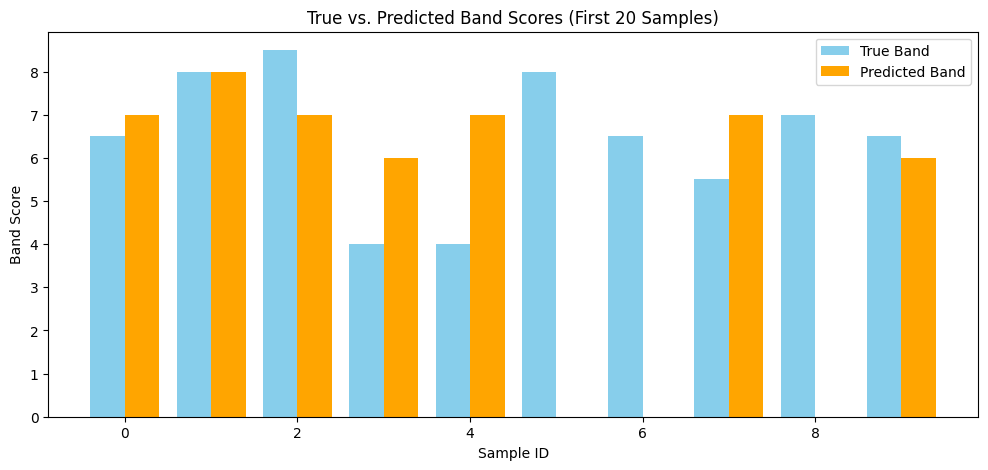

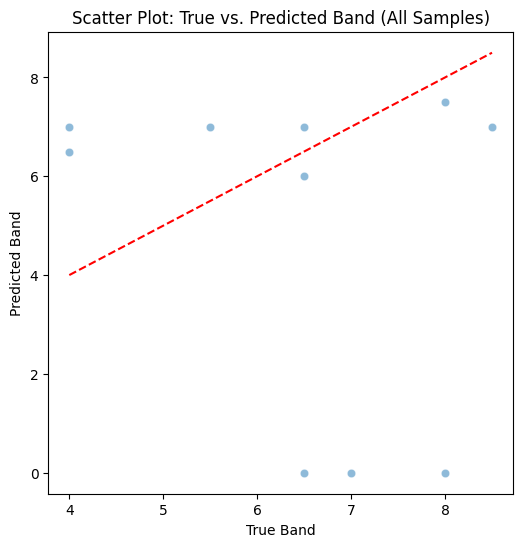

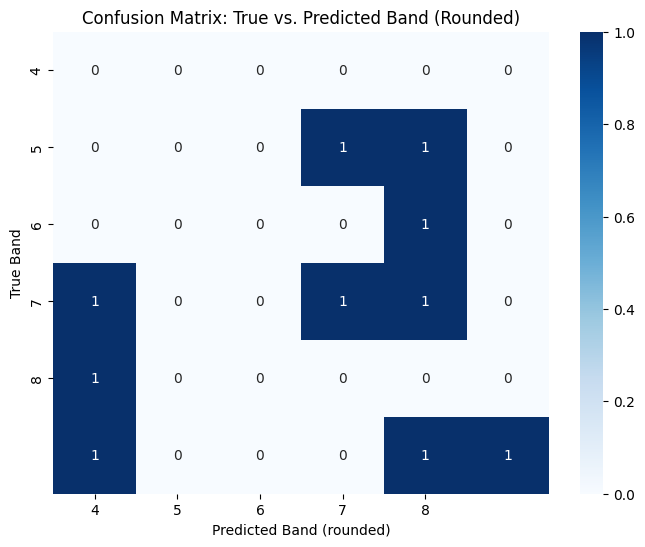


Summary statistics:
       band_true  band_pred
count  10.000000     10.000
mean    6.450000      4.800
std     1.571447      3.335
min     4.000000      0.000
25%     5.750000      1.500
50%     6.500000      6.750
75%     7.750000      7.000
max     8.500000      7.500

Evaluation Metrics:
     Metric     Value
0       MAE  3.150000
1      RMSE  4.192255
2       QWK -0.057143
3   Pearson -0.277737
4  Spearman -0.035496


In [19]:
# Section 13: Display comparison table and plots of predictions and ground truth
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check if we have valid data for visualization
if len(df_pred) == 0:
    print("No valid data available for visualization!")
else:
    # Show table
    subset = df_pred[['id', 'band_true', 'band_pred', 'band_pred_round']].head(20)
    print("Sample of predictions:")
    print(subset)
    
    # Bar plot: predicted vs. true band scores
    plt.figure(figsize=(12,5))
    plt.bar(subset['id']-0.2, subset['band_true'], width=0.4, label='True Band', color='skyblue')
    plt.bar(subset['id']+0.2, subset['band_pred_round'], width=0.4, label='Predicted Band', color='orange')
    plt.xlabel('Sample ID')
    plt.ylabel('Band Score')
    plt.title('True vs. Predicted Band Scores (First 20 Samples)')
    plt.legend()
    plt.show()
    
    # Scatter plot: all predictions
    plt.figure(figsize=(6,6))
    sns.scatterplot(x='band_true', y='band_pred', data=df_pred, alpha=0.5)
    plt.plot([df_pred['band_true'].min(), df_pred['band_true'].max()], [df_pred['band_true'].min(), df_pred['band_true'].max()], 'r--')
    plt.xlabel('True Band')
    plt.ylabel('Predicted Band')
    plt.title('Scatter Plot: True vs. Predicted Band (All Samples)')
    plt.show()
    
    # Confusion matrix (rounded) - only if we have valid integer values
    try:
        cm = confusion_matrix(df_pred['band_true'].astype(int), df_pred['band_pred_round'].astype(int))
        plt.figure(figsize=(8,6))
        unique_labels = sorted(df_pred['band_true'].astype(int).unique())
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=unique_labels, yticklabels=unique_labels)
        plt.xlabel('Predicted Band (rounded)')
        plt.ylabel('True Band')
        plt.title('Confusion Matrix: True vs. Predicted Band (Rounded)')
        plt.show()
    except Exception as e:
        print(f"Could not create confusion matrix: {e}")
        print("Band true range:", df_pred['band_true'].min(), "to", df_pred['band_true'].max())
        print("Band pred range:", df_pred['band_pred'].min(), "to", df_pred['band_pred'].max())
    
    # Summary statistics
    print('\nSummary statistics:')
    print(df_pred[['band_true', 'band_pred']].describe())
    
    # Table of evaluation metrics (only if metrics were calculated)
    if 'mae' in locals():
        import pandas as pd
        metrics_table = pd.DataFrame({
            'Metric': ['MAE', 'RMSE', 'QWK', 'Pearson', 'Spearman'],
            'Value': [mae, rmse, qwk, pearson, spearman]
        })
        print('\nEvaluation Metrics:')
        print(metrics_table)
    else:
        print("\nNo evaluation metrics available - data cleaning may have failed.")

In [20]:
# Section 14: Save test set prediction results to file
output_path = '/kaggle/working/ielts_task2_predictions.csv'
df_pred.to_csv(output_path, index=False)
print(f"Saved predictions to {output_path}")

Saved predictions to /kaggle/working/ielts_task2_predictions.csv
